<a href="https://colab.research.google.com/github/IsharaSilva/Prediction-Recommedation-system-for-Potato-Cultivation/blob/main/Detection_of_Healthy_Unhealthy_Leaves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
!git clone https://github.com/IsharaSilva/Prediction-Recommedation-system-for-Potato-Cultivation.git

Cloning into 'Prediction-Recommedation-system-for-Potato-Cultivation'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 232 (delta 79), reused 0 (delta 0), pack-reused 113
Receiving objects: 100% (232/232), 64.12 MiB | 17.23 MiB/s, done.
Resolving deltas: 100% (149/149), done.


In [1]:
import cv2
import joblib
import numpy as np # dataAnalysis
import pandas as pd #multidimensional arrays
import matplotlib.pyplot as plt #data visualization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage import img_as_ubyte
from skimage.util import img_as_float

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
path = os.listdir('/content/drive/MyDrive//Dataset/Training')
classes = {'Healthy':0, 'Virus':1, 'Fungal':2,'Insect':3}

# **Image preprocessing and segmentation**

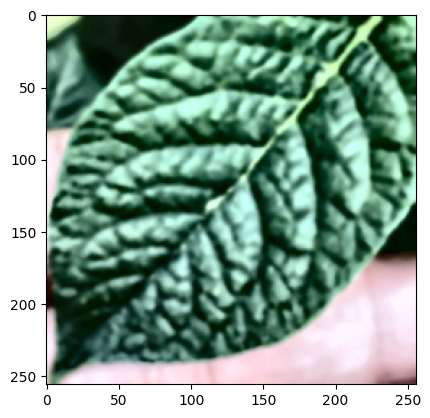

In [ ]:
import cv2
import os
import numpy as np

input_dir = '/content/drive/MyDrive/Dataset/Training/'
output_dir = '/content/drive/MyDrive/Dataset/Preprocessed/'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define the list of transformations
transformations = [
    ('rotation', cv2.ROTATE_90_CLOCKWISE),  # Rotate the image 90 degrees clockwise
    ('translation', np.float32([[1, 0, 50], [0, 1, 50]])),  # Translate the image by 50 pixels in both x and y directions
    ('scaling', np.float32([[0.5, 0, 0], [0, 0.5, 0]])),  # Scale down the image by 0.5
    ('flipping', 0),  # Flip the image horizontally
    #('noise', 30)  # Add Gaussian noise with mean=0 and standard deviation=30
]

x = []
y = []

for cls in classes:
    pth = os.path.join(input_dir, cls)
    for j in os.listdir(pth):
        img = cv2.imread(os.path.join(pth, j))
        img1 = cv2.resize(img, (256, 256))  # Image resizing
        img1 = cv2.medianBlur(img1, 5)  # Apply median filter to remove noise
        img1 = img_as_ubyte(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))  # Contrast improvement

        # Convert the image to LAB color space
        img1_lab = cv2.cvtColor(img1, cv2.COLOR_RGB2LAB)

        # Split the LAB image into separate channels
        img1_lab_planes = cv2.split(img1_lab)

        # Apply histogram equalization to the L channel
        img1_lab_planes = list(img1_lab_planes)
        img1_lab_planes[0] = cv2.equalizeHist(img1_lab_planes[0])
        img1_lab_planes = tuple(img1_lab_planes)

        # Merge the planes and convert back to RGB
        img1_lab = cv2.merge(img1_lab_planes)
        img1 = cv2.cvtColor(img1_lab, cv2.COLOR_LAB2RGB)

        # Smoothing
        img1 = cv2.GaussianBlur(img1, (5, 5), 0)

        # CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img1_lab_planes = cv2.split(cv2.cvtColor(img1, cv2.COLOR_RGB2LAB))
        img1_lab_planes = list(img1_lab_planes)
        img1_lab_planes[0] = clahe.apply(img1_lab_planes[0])
        img1_lab_planes = tuple(img1_lab_planes)
        img1_lab = cv2.merge(img1_lab_planes)
        img1 = cv2.cvtColor(img1_lab, cv2.COLOR_LAB2RGB)

        # Save preprocessed image
        output_path = os.path.join(output_dir, cls, j)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        cv2.imwrite(output_path, img1)

        # Append the preprocessed image and original image to the lists
        x.append(img1)
        y.append(img)

        # Apply transformations to the image
        for transform_name, transform_param in transformations:
            transformed_img = img1.copy()

            if transform_name == 'rotation':
                transformed_img = cv2.rotate(transformed_img, transform_param)
            elif transform_name == 'translation':
                M = transform_param
                transformed_img = cv2.warpAffine(transformed_img, M, (img1.shape[1], img1.shape[0]))
            elif transform_name == 'scaling':
                M = transform_param
                transformed_img = cv2.warpAffine(transformed_img, M, (int(img1.shape[1]*0.5), int(img1.shape[0]*0.5)))
            elif transform_name == 'flipping':
                transformed_img = cv2.flip(transformed_img, transform_param)
            #elif transform_name == 'noise':
                #noise = np.random.normal(0, transform_param, img1.shape).astype(np.uint8)
                #transformed_img = cv2.add(transformed_img, noise)

            # Save the transformed image
            output_path = os.path.join(output_dir, cls, f'{transform_name}_{j}')
            cv2.imwrite(output_path, transformed_img)

# Display the preprocessed image
plt.imshow(x[0])


In [ ]:
print(transformed_img.shape)

(256, 256, 3)


# **Feature extraction**

In [8]:
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
from sklearn.feature_selection import f_classif

preprocessed_dir = '/content/drive/MyDrive/Dataset/Preprocessed/'
features = []
labels = []

# GLCM parameters
distances = [1]
angles = [0]

for cls in classes:
    pth = os.path.join(preprocessed_dir, cls)
    for j in os.listdir(pth):
        img_path = os.path.join(pth, j)
        img = cv2.imread(img_path)

        # Split RGB image into channels
        blue, green, red = cv2.split(img)

        # Calculate mean and standard deviation for each channel
        mean_blue = blue.mean()
        mean_green = green.mean()
        mean_red = red.mean()
        std_dev_blue = blue.std()
        std_dev_green = green.std()
        std_dev_red = red.std()

        # Convert RGB image to HSV
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Split HSV image into channels
        hue, saturation, value = cv2.split(hsv_img)

        # Calculate mean hue
        mean_hue = hue.mean()

        # Convert RGB image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Compute GLCM
        glcm = greycomatrix(gray_img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

        # Compute GLCM properties
        contrast = greycoprops(glcm, prop='contrast')[0, 0]
        dissimilarity = greycoprops(glcm, prop='dissimilarity')[0, 0]
        homogeneity = greycoprops(glcm, prop='homogeneity')[0, 0]
        energy = greycoprops(glcm, prop='energy')[0, 0]
        correlation = greycoprops(glcm, prop='correlation')[0, 0]

        # Calculate ASM and entropy
        asm = (glcm**2).sum()
        entropy = shannon_entropy(gray_img)

        # Store the extracted features and labels
        feature = [
            contrast, dissimilarity, homogeneity, energy, correlation,
            asm, entropy,
            mean_hue, mean_red, mean_green, mean_blue,
            std_dev_red, std_dev_green, std_dev_blue
        ]
        features.append(feature)
        labels.append(cls)

# Convert features and labels to numpy arrays
X = np.array(features)
y = np.array(labels)

# Define the feature names
feature_names = [
    "Contrast", "Dissimilarity", "Homogeneity", "Energy", "Correlation",
    "ASM", "Entropy",
    "Mean Hue", "Mean Red", "Mean Green", "Mean Blue",
    "Std Dev Red", "Std Dev Green", "Std Dev Blue"
]

# Perform ANOVA test
f_values, p_values = f_classif(X, y)

# Create a list of tuples containing the feature name, F-value, and p-value
feature_scores = [(feature_names[i], f_val, p_val) for i, (f_val, p_val) in enumerate(zip(f_values, p_values))]

# Sort the feature scores based on the F-values in descending order
sorted_feature_scores = sorted(feature_scores, key=lambda x: x[1], reverse=True)

# Print the ANOVA test results for each feature
for feature in sorted_feature_scores:
    feature_name, f_val, p_val = feature
    print(f"{feature_name}, : F-value={f_val}, p-value={p_val}")



Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0

Mean Hue, : F-value=2038.4207583001892, p-value=0.0
Mean Blue, : F-value=273.29306818036116, p-value=1.1632138264456419e-168
Std Dev Blue, : F-value=174.46061202269104, p-value=1.7930300308571961e-109
Std Dev Red, : F-value=159.35530330207897, p-value=3.026332391238571e-100
Std Dev Green, : F-value=102.27449612362553, p-value=6.1897632086441065e-65
Homogeneity, : F-value=33.556557275277875, p-value=1.5305510060458635e-21
Mean Red, : F-value=29.38048082495078, p-value=6.9953998977802815e-19
Entropy, : F-value=26.853176919771688, p-value=2.848960090944793e-17
ASM, : F-value=24.844769843996012, p-value=5.418155341328635e-16
Mean Green, : F-value=19.19136504654371, p-value=2.1467681095647927e-12
Energy, : F-value=19.09267299631677, p-value=2.4804604772544557e-12
Dissimilarity, : F-value=7.690754496936466, p-value=3.962218172361262e-05
Contrast, : F-value=7.003103326043763, p-value=0.00010616763821262523
Correlation, : F-value=3.559267488605953, p-value=0.01364357363648024


**Texture Properties - energy, ASM, entropy**

**Color Properties - mean hue, mean red, mean green, mean blue, standard deviation hue, standard deviation red, standard deviation green, and standard deviation blue**

In [14]:
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
import cv2
import os

preprocessed_dir = '/content/drive/MyDrive/Dataset/Preprocessed/'
features = []
labels = []

# GLCM parameters
distances = [1]
angles = [0]

for cls in classes:
    pth = os.path.join(preprocessed_dir, cls)
    for j in os.listdir(pth):
        img_path = os.path.join(pth, j)
        img = cv2.imread(img_path)

        # Split RGB image into channels
        blue, green, red = cv2.split(img)

        # Calculate mean and standard deviation for each channel
        mean_blue = blue.mean()
        mean_green = green.mean()
        mean_red = red.mean()
        std_dev_blue = blue.std()
        std_dev_green = green.std()
        std_dev_red = red.std()

        # Convert RGB image to HSV
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Split HSV image into channels
        hue, saturation, value = cv2.split(hsv_img)

        # Calculate mean hue
        mean_hue = hue.mean()

        # Convert RGB image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Compute GLCM
        glcm = greycomatrix(gray_img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

        # Compute GLCM properties
        #contrast = greycoprops(glcm, prop='contrast')[0, 0]
        #dissimilarity = greycoprops(glcm, prop='dissimilarity')[0, 0]
        homogeneity = greycoprops(glcm, prop='homogeneity')[0, 0]
        #energy = greycoprops(glcm, prop='energy')[0, 0]
        #correlation = greycoprops(glcm, prop='correlation')[0, 0]


        # Calculate ASM and entropy
        asm = (glcm**2).sum()
        entropy = shannon_entropy(gray_img)

        # Store the extracted features and labels
        feature = [
            #contrast,
            #dissimilarity,
            homogeneity,
            #energy,
            #correlation,
            asm,
            entropy,
            mean_hue,
            mean_red,
            mean_green,
            mean_blue,
            std_dev_red,
            std_dev_green,
            std_dev_blue
        ]
        features.append(feature)
        labels.append(cls)

# Print the extracted features and labels for each image
for i, feature in enumerate(features):
    print(f"Image {i+1}: Features={feature}, Label={labels[i]}")


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version=

Streaming output truncated to the last 5000 lines.
Image 2792: Features=[0.44671125940073253, 0.11522578209008406, 6.105574252477653, 36.8758544921875, 74.42056274414062, 94.53627014160156, 68.97297668457031, 74.64387643559085, 87.37768164504237, 68.91134533555591], Label=Virus
Image 2793: Features=[0.11069826508652969, 0.00013268306565910004, 7.894100384628514, 59.9354248046875, 101.3468017578125, 131.24517822265625, 98.0865478515625, 68.94082867520227, 70.18637825685919, 67.05846133063217], Label=Virus
Image 2794: Features=[0.056978064115095026, 0.0001778728950028234, 7.296003402258933, 68.56765747070312, 185.304931640625, 200.71849060058594, 183.3258819580078, 59.17458443423221, 56.76722589386926, 56.66384964842857], Label=Virus
Image 2795: Features=[0.152884054310788, 0.00015941263482644895, 7.845567450765781, 54.61351013183594, 95.39599609375, 133.8061065673828, 86.00001525878906, 62.946473299259885, 67.89986420295088, 67.34147611173216], Label=Virus
Image 2796: Features=[0.188288

**Classification**

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import joblib

# Load the features and labels
X = np.array(features)
y = np.array(labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the random forest
    'max_depth': [None, 5, 10],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt'],  # Number of features to consider when looking for the best split
    'random_state': [42]
}

# Create the RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its performance on the test set
best_rf_classifier = grid_search.best_estimator_
y_pred = best_rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_report_data = classification_report(y_test, y_pred)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best Parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}
Best Score: 0.9062880930284045


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Set the best parameters obtained from GridSearchCV
best_params = {
    'max_depth': None,
    'max_features': 'auto',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 200,
    'random_state': 42
}

# Create the RandomForestClassifier with the best parameters
rf_classifier = RandomForestClassifier(**best_params)

# Train the model on the training data
rf_classifier.fit(X_train, y_train)

# Predict the labels for the testing data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
classification_report_data = classification_report(y_test, y_pred)

# Specify the file path to save the model
model_path = '/content/drive/MyDrive/Dataset/saved_model.pkl'

# Save the trained model
joblib.dump(best_rf_classifier, model_path)

# Print the accuracy and classification report
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report_data)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy: 0.9339320076972418
Classification Report:
              precision    recall  f1-score   support

      Fungal       0.98      0.98      0.98       358
     Healthy       0.94      0.88      0.91       428
      Insect       0.96      0.94      0.95       349
       Virus       0.87      0.95      0.91       424

    accuracy                           0.93      1559
   macro avg       0.94      0.94      0.94      1559
weighted avg       0.94      0.93      0.93      1559



**Random forest**

In [18]:
import os
import joblib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Convert the feature list and labels to numpy arrays
X = np.array(features)
y = np.array(labels)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Specify the file path to save the model
model_path = '/content/drive/MyDrive/Dataset/saved_model.pkl'

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Save the trained model to a file
joblib.dump(rf_classifier, model_path)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report)


Accuracy: 0.9300833867864016
Classification Report:
              precision    recall  f1-score   support

      Fungal       0.97      0.98      0.98       358
     Healthy       0.94      0.87      0.90       428
      Insect       0.96      0.94      0.95       349
       Virus       0.86      0.95      0.90       424

    accuracy                           0.93      1559
   macro avg       0.94      0.93      0.93      1559
weighted avg       0.93      0.93      0.93      1559



In [ ]:
# Determine the number of images in the training dataset
num_train_images = X_train.shape[0]
print("Number of images in the training dataset:", num_train_images)

# Determine the number of images in the testing dataset
num_test_images = X_test.shape[0]
print("Number of images in the testing dataset:", num_test_images)

Number of images in the training dataset: 6232
Number of images in the testing dataset: 1559


# **Testing**


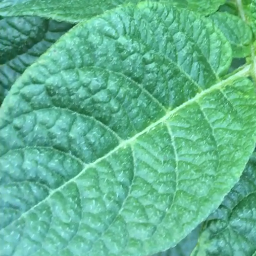

Predicted Label: Healthy


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


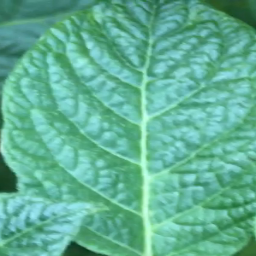

Predicted Label: Healthy


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


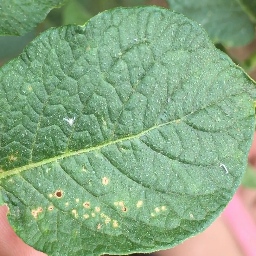

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


Predicted Label: Virus


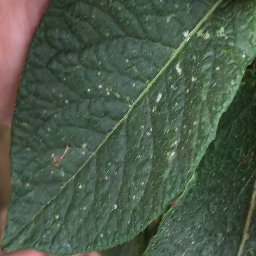

Predicted Label: Virus


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


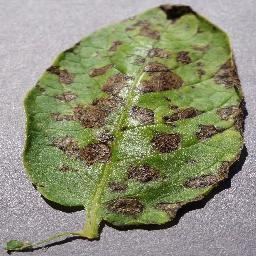

Predicted Label: Fungal


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


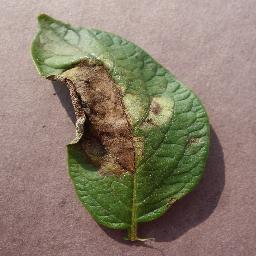

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


Predicted Label: Fungal


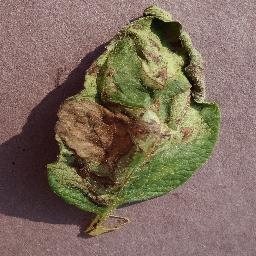

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


Predicted Label: Fungal


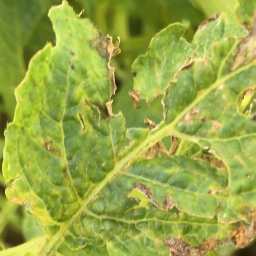

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


Predicted Label: Insect


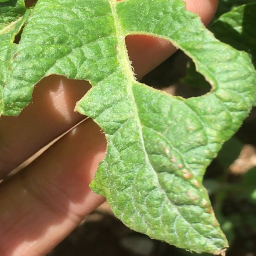

Predicted Label: Insect


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


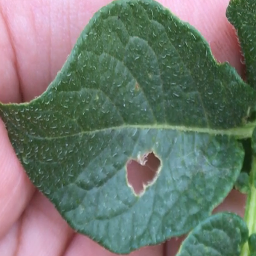

Predicted Label: Insect


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


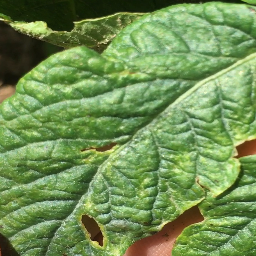

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


Predicted Label: Insect


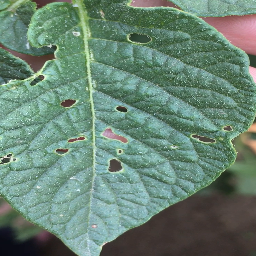

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


Predicted Label: Insect
Testing Accuracy: 0.9166666666666666
Classification Report:
              precision    recall  f1-score   support

      Fungal       1.00      0.75      0.86         4
     Healthy       1.00      1.00      1.00         2
      Insect       0.80      1.00      0.89         4
       Virus       1.00      1.00      1.00         2

    accuracy                           0.92        12
   macro avg       0.95      0.94      0.94        12
weighted avg       0.93      0.92      0.92        12



In [88]:
import cv2
import os
import joblib
import numpy as np
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
from sklearn.metrics import accuracy_score, classification_report
from google.colab.patches import cv2_imshow

test_dir = '/content/drive/MyDrive/Dataset/Testing/'
model_path = '/content/drive/MyDrive/DataNew/saved_model_New.pkl'

classes = {'Healthy': 0, 'Virus': 1, 'Fungal': 2, 'Insect': 3}
true_labels = []
predicted_labels = []

# Load the trained classifier
classifier = joblib.load(model_path)

for cls in classes:
    class_dir = os.path.join(test_dir, cls)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)

        img = cv2.resize(img, (256, 256))
        cv2_imshow(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        img_lab_planes = cv2.split(img_lab)
        img_lab_planes = list(img_lab_planes)
        img_lab_planes[0] = cv2.equalizeHist(img_lab_planes[0])
        img_lab_planes = tuple(img_lab_planes)
        img_lab = cv2.merge(img_lab_planes)
        img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)

        blue, green, red = cv2.split(img)
        mean_blue, mean_green, mean_red = blue.mean(), green.mean(), red.mean()
        std_dev_blue, std_dev_green, std_dev_red = blue.std(), green.std(), red.std()
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hue = hsv_img[:, :, 0].mean()
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        glcm = greycomatrix(gray_img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        energy = greycoprops(glcm, prop='energy')[0, 0]
        asm = (glcm ** 2).sum()
        entropy = shannon_entropy(gray_img)
        features = [energy, asm, entropy, hue, mean_red, mean_green, mean_blue, std_dev_red, std_dev_green,
                    std_dev_blue]

        features = np.array(features)
        features = features.reshape(1, -1)
        predicted_label = classifier.predict(features)[0]

        print('Predicted Label:', predicted_label)

        true_labels.append(cls)  # Store the true label
        predicted_labels.append(predicted_label)  # Store the predicted label

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Testing Accuracy:", accuracy)

# Display classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))
